In [2]:
from pylab import *
#import random_idx
from __future__ import division
import scipy
import scipy.special
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


In [3]:

def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_snr(s, D=27, ares=2000):
    p = np.zeros((ares-1, len(s)))

    for isnr, snr in enumerate(s):
        # span the Hit distribution up to 8 standard deviations @todo: make parameter
        avals = np.linspace(snr - 8, snr + 8, ares)
        
        # the discretized gaussian of the hit
        p[:, isnr] = ncdf((avals[1:]-snr)) - ncdf((avals[:-1]-snr))
        # times the discretized cumulative gaussian of the reject
        p[:, isnr] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0))) ** (D-1)
        
    return np.sum(p, axis=0) # integrate over the avals


def p_correct_decay(M,ll=1, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    dM = (1 / (1 - ll**2))
    
    for iM,Mval in enumerate(M):
        avals = np.linspace(N * ll ** Mval - 8 * (N*dM)**0.5, N * ll ** Mval + 8 * (N*dM)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N * ll ** Mval) / ((dM)*N)**0.5) - ncdf((avals[:-1]-N * ll ** Mval) / ((dM)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(dM*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [4]:

def p_correct_l(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

## Clipping


In [5]:
def test_capacity_clipping(N, D, K=5, clip=10, trials=5e3):
    '''
    Runs a capacity experiment with noise in the dereferencing vector.
    '''
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)
    
    for i in range(int(trials)-1):
        
        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]
        
        hypercapacity[hypercapacity > clip] = clip
        hypercapacity[hypercapacity < -clip] = -clip  

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [8]:
def test_capacity_clipping_lookback(N, D, clip=10, trials=25e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        hypercapacity[hypercapacity > clip] = clip
        hypercapacity[hypercapacity < -clip] = -clip
        
        v_last_input = np.roll(hypercapacity, -1)
        #v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        #lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))
        
    # instead of keeping a single K, going to look back with increasing K at the end
    for i in range(int(trials)):
        v_input_K = np.roll(hypercapacity, -(int(trials)-i-1))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input, hypercapacity

In [127]:
N = 5000
test_clip = [1, 3, 5, 10, 20, 40, 80]
#test_clip = arange(8) + 1

runs = 15

run_id = []
run_clip = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

clip_mean_all = []
clip_var_all = []

lv = 2*(np.random.randn < 0) -1 

for r in range(runs):
    print r
    for clip in test_clip:
        lidx, lidx_li, lidx_iK, lidx_fi, hypvec = test_capacity_clipping_lookback(N, len(random_idx.alphabet), clip=clip)
        
        run_id.append(r)
        run_clip.append(clip)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
        clip_mean_all.append(np.dot(lv,hypvec))
        clip_var_all.append(var(hypvec))
        
        
filename = 'data/capacity-clip-lookback-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_clip=run_clip, runs=runs, N=N, D=len(random_idx.alphabet), test_clip=test_clip)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

Duration:  10.7413630486
Duration:  10.1094510555
Duration:  9.99164199829
Duration:  9.66489696503
Duration:  9.45702314377
Duration:  9.40295505524
Duration:  9.38167595863
1
Duration:  10.391283989
Duration:  9.82570004463
Duration:  9.66720485687
Duration:  9.51653122902
Duration:  9.45754599571
Duration:  10.8569700718
Duration:  10.6251859665
2
Duration:  11.6526210308
Duration:  10.3314509392
Duration:  10.179338932
Duration:  9.70272779465
Duration:  9.61380910873
Duration:  10.3243589401
Duration:  9.8063659668
3
Duration:  10.3231117725
Duration:  9.78619408607
Duration:  9.62913799286
Duration:  9.54239702225
Duration:  9.43905997276
Duration:  9.37450289726
Duration:  9.34588694572
4
Duration:  10.2664418221
Duration:  9.79470205307
Duration:  9.66934204102
Duration:  9.49988603592
Duration:  9.43053007126
Duration:  9.38570094109
Duration:  9.35728907585
5
Duration:  10.253098011
Duration:  9.79188585281
Duration:  9.64146995544
Duration:  9.5136089325
Duration:  9.4447748

In [108]:
K=25
N = 5000
test_clip = [1, 3, 5, 10, 20, 40, 80]
D=27
runs = 5

run_id = []
run_clip = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for clip in test_clip:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_clipping(N, D=27, K=K, clip=clip)
        
        run_id.append(r)
        run_clip.append(clip)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/capacity-clip-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all, K=K,
        run_id=run_id, run_clip=run_clip, runs=runs, N=N, D=len(random_idx.alphabet), test_clip=test_clip)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-pac

Duration:  2.37294816971
Duration:  2.19395303726


KeyboardInterrupt: 

In [341]:
#h = np.load('data/hypervector_capacity_decay-d=0.998-N=1-D=3-r=5-n160518.npz')
#h = np.load('data/capacity-clip-lookback-N=5000-tc=7-r=15-n160623.npz')
h = np.load('data/capacity-clip-lookback-N=5000-tc=7-r=15-n160623.npz')
clip_mean_all = []
clip_var_all = []

#lv = 2*(np.random.randn < 0) -1 

lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_clip = h['run_clip']
test_clip = h['test_clip']
runs = h['runs']
N = h['N']
D = h['D']
#K = h['K']

In [342]:
K=25

In [343]:
run_id = np.array(run_id)
run_clip = np.array(run_clip)

uclip = unique(run_clip)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uclip)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uclip)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uclip)))

for idx_clip, clip in enumerate(uclip):
    idxs = find(run_clip==clip)
    for i in idxs:
        li_mean[:,idx_clip] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,idx_clip] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,idx_clip] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


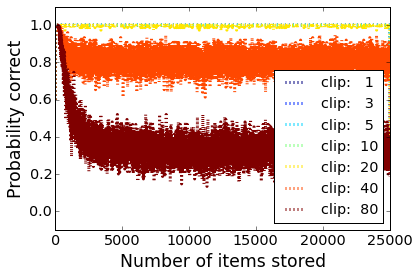

In [344]:
figure(figsize=(6,4))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         ':', color=cm(i), lw=3, label="clip: %3d" % test_clip[i])


M = np.arange(li_mean.shape[0])

#for idx_clip, clip in enumerate(test_clip):
#    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
#    plot(M, p_correct, color=cm(idx_clip),lw=3, label="clip: %3d" % clip)


legend(loc='lower right');
#title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored');
ylabel('Probability correct')
ylim([-0.1, 1.1])
savefig('figures/capacity_clipping-N=' + str(N) +'-tc=' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity_clipping-N='+ str(N) + '-tc=' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

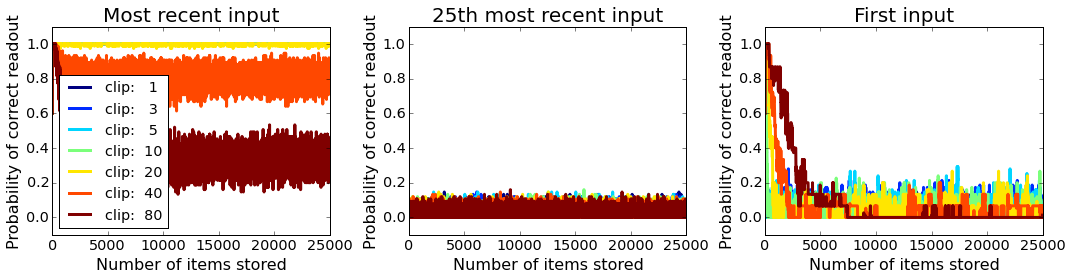

In [345]:
figure(figsize=(15,4))

subplot(131)
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-smoothN//2], 
         color=cm(i), lw=3, label="clip: %3i" % test_clip[i])
    
legend(loc='lower left');
title('Most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])

subplot(132)
cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-22],
         color=cm(i), lw=3, label="clip: %3i" % test_clip[i])
    
#legend(loc='lower left');
title('%dth most recent input' % K, fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])

subplot(133)
cm=get_cmap('jet', li_mean.shape[1])

for i in range(fi_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         color=cm(i), lw=3, label="clip: %3i" % test_clip[i])
    
#legend(loc='lower left');
title('First input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
ylim([-0.1, 1.1])
plt.tight_layout()

savefig('figures/capacity-clipping-recency-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clipping-recency-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [346]:
run_id = np.array(run_id)
run_clip = np.array(run_clip)

uclip = unique(run_clip)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uclip)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uclip)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uclip)))

for idx_clip, clip in enumerate(uclip):
    idxs = find(run_clip==clip)
    for i in idxs:
        li_mean[:,idx_clip] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,idx_clip] += np.array(lidx_all[i] == lidx_iK_all[i], 'int32')  
        fi_mean[:,idx_clip] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


In [347]:
def clip_decay2(lb, clip=5, show_plot=False):
    '''
    Approximates the decay in the hit dot product when there is clipping. 
    '''
    
    # This is going to keep track of how many elements are a value between -clip and + clip
    # We assume that the hypervector is "filled" before a memory item is added. This means
    # that there is a uniform distribution across the values of each element.
    vec = np.ones(2*clip+1) 
    
    # When we add a vector to remember, this distribution shifts. The clipping then
    # causes there to be one less element with value -clip, and one extra element
    # with value clip.
    vec[0] -= 1
    vec[-1] += 1
    
    vec = vec / (2*clip+1)
    
    decay = np.zeros(lb)
    cvar = np.zeros(lb)

    cols = get_cmap('Blues_r', lb+30)

    for l in range(lb):
        # the sum of vec divided by the number of states is the amount the dot product 
        # is reduced.
        if show_plot:
            plt.plot(arange(-clip, clip+1), vec, c=cols(l))
        
        decay[l] = np.sum(vec * arange(-clip, clip+1))
        cvar[l] = np.sum((arange(-clip, clip+1) - decay[l])**2 * vec)
        
        vect = vec.copy()
        
        # As we add more vectors/look back further in the history the distribution of the
        # elements changes. Slowly the distribution returns to uniform.
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2

    return decay, cvar

        

In [348]:
def clip_decay0(lb, clip=5, show_plot=False):
    '''
    Approximates the decay in the hit dot product when there is clipping. 
    '''
    
    # This is going to keep track of how many elements are a value between -clip and + clip
    # We assume that the hypervector is "empty" before a memory item is added. This means
    # that there is a delta distribution at the start
    vec = np.zeros(2*clip+1)
    
    # we know that there is a plus one 
    vec[clip+1] = 1
    
    decay = np.zeros(lb)
    cvar = np.zeros(lb)
    cols = get_cmap('Blues_r', lb+30)
    for l in range(lb):
        # the sum of vec divided by the number of states is the amount the dot product 
        # is reduced.
        if show_plot:
            plt.plot(arange(-clip, clip+1), vec, c=cols(l))
            
        decay[l] = np.sum(vec * arange(-clip, clip+1))
        cvar[l] = np.sum((arange(-clip, clip+1) - decay[l])**2 * vec)
        
        vect = vec.copy()
        
        # As we add more vectors/look back further in the history the distribution of the
        # elements changes. Slowly the distribution returns to uniform.
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2
        

    return decay, cvar

        

In [349]:
def p_correct_clip(M,clip=5, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    dM = ((2.0*clip+1) ** 2.0 -1.0) / 12.0
    
    decay,cvar= clip_decay2(max(M)+1, clip=clip)
    #vdecay = clip_decay_var(max(M)+1, clip=clip)
    
    for iM,Mval in enumerate(M):
        
        val = decay[Mval] * N
        #vval = vdecay[Mval] * N
        vval = dM * N
        
        avals = np.linspace(val - 8 * (vval)**0.5, val+ 8 * (vval)**0.5, ares)
        
        
        p[:, iM] = ncdf((avals[1:] - val) / (vval**0.5)) - ncdf((avals[:-1] - val) / (vval**0.5))
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(dM*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [350]:
def p_correct_clip0(M,clip=5, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    decay, cvar = clip_decay0(max(M)+1, clip=clip)
    #vdecay = clip_decay_var(max(M)+1, clip=clip)
    
    for iM,Mval in enumerate(M):
        
        val = decay[Mval] * N
        #vval = vdecay[Mval] * N
        vval = cvar[Mval] * N
        
        avals = np.linspace(val - 8 * (vval)**0.5, val+ 8 * (vval)**0.5, ares)
        
        
        p[:, iM] = ncdf((avals[1:] - val) / (vval**0.5)) - ncdf((avals[:-1] - val) / (vval**0.5))
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(vval)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

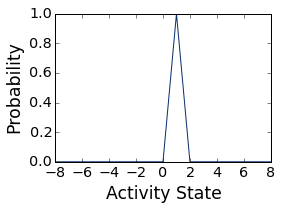

In [351]:
clip=8
figure(figsize=(4,3))

decay, cvar = clip_decay0(1, clip=clip, show_plot=True)

#title('Distribution of elements, clip')
ylabel('Probability')
xlabel('Activity State')
xlim([-clip, clip])
#legend(loc='low left')
plt.tight_layout()

savefig('figures/capacity-clip0-distribution-first-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip0-distribution-first-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)


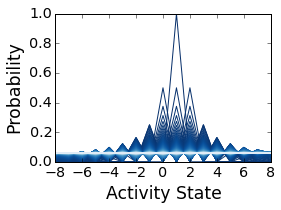

In [352]:
clip=8
figure(figsize=(4,3))

decay, cvar = clip_decay0(250, clip=clip, show_plot=True)

ylabel('Probability')
xlabel('Activity State')
xlim([-clip, clip])
#legend(loc='low left')
plt.tight_layout()

savefig('figures/capacity-clip0-distribution-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip0-distribution-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)


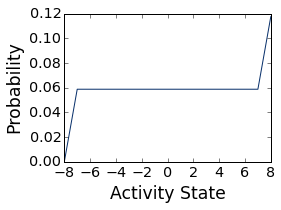

In [353]:
clip=8
figure(figsize=(4,3))

decay,cvar = clip_decay2(1, clip=clip, show_plot=True)

#title('Distribution of elements, clip')
ylabel('Probability')
xlabel('Activity State')
xlim([-clip, clip])
#legend(loc='low left')

plt.tight_layout()
savefig('figures/capacity-clip-s1-first-distribution-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip-s1-first-distribution-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)


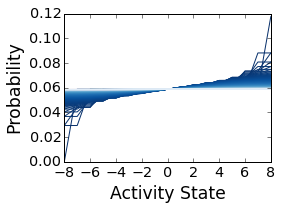

In [354]:
clip=8
figure(figsize=(4,3))

decay, cvar = clip_decay2(250, clip=clip, show_plot=True)

#title('Distribution of elements, clip')
ylabel('Probability')
xlabel('Activity State')
xlim([-clip, clip])
#legend(loc='low left')

plt.tight_layout()
savefig('figures/capacity-clip-s1-distribution-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip-s1-distribution-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)


$$
\boldsymbol{d}(t) = \sum_{j=-\kappa}^{\kappa} j \boldsymbol{s}_j(t)
$$



0 1 2 3 4 5 6 7


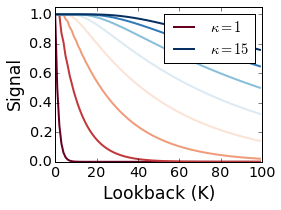

In [355]:
figure(figsize=(4,3))

#test_clip = arange(5)+30
theory_clip = arange(0,15, 2)+1

cm = get_cmap('RdBu', len(theory_clip))
for ic,clip in enumerate(theory_clip):
    print ic,
    
    cdecay, cvar = clip_decay0(100, clip=clip)
    if ic >= 1 and ic < len(theory_clip) - 1:
        plot(cdecay, color=cm(ic), lw=2)
    else:
        plot(cdecay, color=cm(ic), label='$\kappa= %2i$'%clip, lw=2)
    
legend()
ylabel('Signal')
xlabel('Lookback (K)')
ylim([0,1.05])
plt.tight_layout()

savefig('figures/capacity-clip0-degredation' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip0-degredation' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

0 1 2 3 4 5 6 7


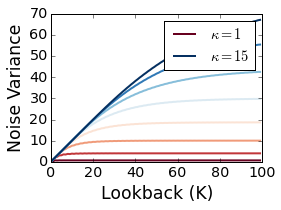

In [356]:
figure(figsize=(4,3))
#test_clip = arange(5)+30

cm = get_cmap('RdBu', len(theory_clip))
for ic,clip in enumerate(theory_clip):
    print ic,
    
    cdecay, cvar = clip_decay0(100, clip=clip)
    if ic >= 1 and ic < len(theory_clip) - 1:
        plot(cvar, color=cm(ic), lw=2)
    else:
        plot(cvar, color=cm(ic), label='$\kappa = %2i$'%clip, lw=2)     
legend()
ylabel('Noise Variance')
xlabel('Lookback (K)')
#ylim([0,1])
plt.tight_layout()

savefig('figures/capacity-clip0-variance-' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip0-variance-' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

0 1 2 3 4 5 6 7


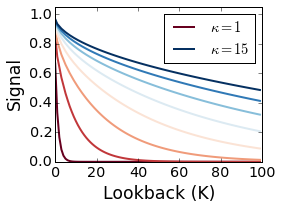

In [357]:
figure(figsize=(4,3))

#test_clip = arange(5)+30
#test_clip =  arange(20) + 1

cm = get_cmap('RdBu', len(theory_clip))
for ic,clip in enumerate(theory_clip):
    print ic,
    
    cdecay, cvar = clip_decay2(100, clip=clip)
    if ic >= 1 and ic < len(theory_clip) - 1:
        plot(cdecay, color=cm(ic), lw=2)
    else:
        plot(cdecay, color=cm(ic), label='$\kappa = %2i$'%clip, lw=2)
    
legend()
ylabel('Signal')
xlabel('Lookback (K)')
ylim([0,1.05])
plt.tight_layout()

savefig('figures/capacity-clip-lb-degredation' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip-lb-degredation' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

0 1 2 3 4 5 6 7


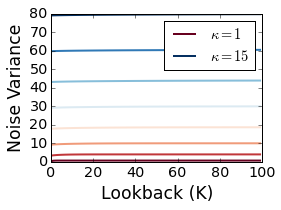

In [358]:
figure(figsize=(4,3))
#test_clip = arange(5)+30
#test_clip =  arange(20) + 1

cm = get_cmap('RdBu', len(theory_clip))
for ic,clip in enumerate(theory_clip):
    print ic,
    
    cdecay, cvar = clip_decay2(100, clip=clip)
    if ic >= 1 and ic < len(theory_clip) - 1:
        plot(cvar, color=cm(ic), lw=2)
    else:
        plot(cvar, color=cm(ic), label='$\kappa = %2i$'%clip, lw=2)
    
legend()
ylabel('Noise Variance')
xlabel('Lookback (K)')
#ylim([0,1])
plt.tight_layout()

savefig('figures/capacity-clip-lb-variance-' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip-lb-variance-' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

figures/capacity-clip0-ncl-4-n170212


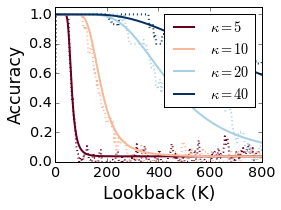

In [359]:
figure(figsize=(4,3))
st_ll = 2

show_clip = np.arange(st_ll, len(test_clip)-1)

cm = get_cmap('RdBu', len(show_clip))

smoothN=5
for ic, i in enumerate(show_clip):
    #plot(li_mean[:,i], color=cm(i))
    plot(arange(fi_mean.shape[0])[:-5],
         np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-5],
         ':', color=cm(ic), lw=2)
    
    #pcd = p_correct_decay(arange(iK_mean.shape[0])+1, ll=decay, N=N, D=test_D[i]) 
    #plot(arange(iK_mean.shape[0]), pcd, lw=3, color=cm(i))

test_ll = [0.5, 0.9552, 0.9875, 0.9975, 0.9992, 0.999755]
M = arange(1000)

#for il,ll in enumerate(test_ll):
for ic, il in enumerate(show_clip):
    clip = test_clip[il]
    #ll = np.sqrt(1 - (12.0 / ((2*clip+1)**2 - 1)))
    #plot(M, p_correct_decay(M, N=N, ll=ll), '--', color=cm(il), lw=2)
    plot(M, p_correct_clip0(M, N=N, clip=clip), color=cm(ic), lw=2, 
        label="$\kappa= %3i$" % test_clip[il])
    
legend(loc='upper right');
#title(r'Readout from end', fontsize=20);
xlabel('Lookback (K)');
ylabel('Accuracy')
ax = gca()
ax.set_xticks(arange(0, 801, 200))
xlim([0, 800])
ylim([0, 1.05])
plt.tight_layout()
#xscale('log')
#yscale('log')
fname = ('figures/capacity-clip0-ncl-' + str(len(show_clip))
         + '-n' + time.strftime('%y%m%d'))
print fname

savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/capacity-clipping-lookback-ncl=4-n170212


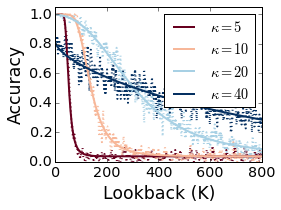

In [360]:
figure(figsize=(4,3))

smoothN=5


for ic, i in enumerate(show_clip):
    #plot(li_mean[:,i], color=cm(i))
    plot(arange(iK_mean.shape[0], 0, -1)[:-5],
         np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-5],
         ':', color=cm(ic), lw=2)
    
    #pcd = p_correct_decay(arange(iK_mean.shape[0])+1, ll=decay, N=N, D=test_D[i]) 
    #plot(arange(iK_mean.shape[0]), pcd, lw=3, color=cm(i))

M = arange(1000)

#for il,ll in enumerate(test_ll):
for ic, il in enumerate(show_clip):
    clip = test_clip[il]
    #ll = np.sqrt(1 - (12.0 / ((2*clip+1)**2 - 1)))
    #plot(M, p_correct_decay(M, N=N, ll=ll), '--', color=cm(il), lw=2)
    plot(M, p_correct_clip(M, N=N, clip=clip), color=cm(ic), lw=2, 
        label="$\kappa= %3i$" % test_clip[il])
    
legend(loc='upper right');
#title(r'Readout from end', fontsize=20);
xlabel('Lookback (K)');
ylabel('Accuracy')
ax = gca()
ax.set_xticks(arange(0, 801, 200))
xlim([0, 800])
ylim([0, 1.05])
plt.tight_layout()
#xscale('log')
#yscale('log')

fname = ('figures/capacity-clipping-lookback-ncl=' + str(len(show_clip))
         + '-n' + time.strftime('%y%m%d'))
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/capacity-clipping-info_theory-lookback-ncl=4-n170212


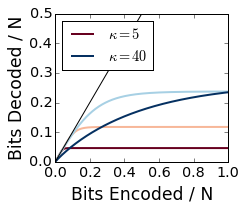

In [361]:
figure(figsize=(3.5,3))

M = arange(N)+1
D = 27

#for il,ll in enumerate(test_ll):
for ic, il in enumerate(show_clip):
    clip = test_clip[il]
    #ll = np.sqrt(1 - (12.0 / ((2*clip+1)**2 - 1)))
    #plot(M, p_correct_decay(M, N=N, ll=ll), '--', color=cm(il), lw=2)
    
    pc = p_correct_clip(M, N=N, D=D, clip=clip);
    clip_info = np.cumsum(pc * np.log2(pc*D) + (1-pc) * np.log2(D/(D-1) * (1-pc)))
    
    if ic == 0 or ic == len(show_clip)-1:
        plot(M * np.log2(D) / N, clip_info / N, color=cm(ic), lw=2, 
            label="$\kappa= %3i$" % test_clip[il])
    else:
        plot(M * np.log2(D) / N, clip_info / N, color=cm(ic), lw=2)


plot([0, 1], [0, 1], 'k')
legend(loc='upper left');
#title(r'Readout from end', fontsize=20);
xlabel('Bits Encoded / N');
ylabel('Bits Decoded / N')
ax = gca()
xlim([0, 1])
ylim([0, 0.5])
plt.tight_layout()
#xscale('log')
#yscale('log')

fname = ('figures/capacity-clipping-info_theory-lookback-ncl=' + str(len(show_clip))
         + '-n' + time.strftime('%y%m%d'))
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/capacity-clipping-info_theory-lookback-D-nD=6-N=4000-n170212


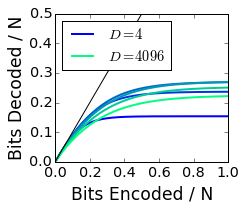

In [362]:
figure(figsize=(3.5,3))


N=4000
clip = 20
M = arange(N)+1

test_D = [4, 16, 64, 256, 1024, 4096]

cm = get_cmap('winter', len(test_D))

for iD, D in enumerate(test_D):
 
    pc = p_correct_clip(M, N=N, D=D, clip=clip);
    clip_info = np.cumsum(pc * np.log2(pc*D) + (1-pc) * np.log2(D/(D-1) * (1-pc)))
    
    if iD == 0 or iD == len(test_D)-1:
        plot(M * np.log2(D) / N, clip_info / N, color=cm(iD), lw=2, 
            label="$D = %i$" % D)
    else:
        plot(M * np.log2(D) / N, clip_info / N, color=cm(iD), lw=2)


plot([0, 1], [0, 1], 'k')
legend(loc='upper left');

xlabel('Bits Encoded / N');
ylabel('Bits Decoded / N')
ax = gca()
xlim([0, 1])
ylim([0, 0.5])
plt.tight_layout()

fname = ('figures/capacity-clipping-info_theory-lookback-D-nD=' + str(len(test_D))
         + '-k=' + str(clip)
         + '-N=' + str(N)
         + '-n' + time.strftime('%y%m%d'))
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

In [326]:
N

2000

In [276]:
test_N = [1000, 2000, 4000]
test_D = [4, 16, 64, 256, 1024, 4096]
test_clip = np.arange(2, 100, 2)

clip_info_max = np.zeros((len(test_N), len(test_D), len(test_clip)))

for iN, vN in enumerate(test_N):
    print vN,
    tst = time.time()
    for iD, vD in enumerate(test_D):
        print vD,
        for ic, clip in enumerate(test_clip):
            pc = p_correct_clip(M, N=vN, D=vD, clip=clip);
            clip_info = np.sum(pc * np.log2(pc*vD) + (1-pc) * np.log2(vD/(vD-1) * (1-pc)))
            clip_info_max[iN, iD, ic] = clip_info
    print 'Elapsed, ', time.time() - tst
    


1000 4 16 64 256 1024 4096 Elapsed,  815.575028896
2000 4 16 64 256 1024 4096 Elapsed,  853.152040005
4000 4 16 64 256 1024 4096 Elapsed,  834.693489075


figures/capacity-clipping-info_max_lookback-nN=3-nD=6-nk=49-n170208


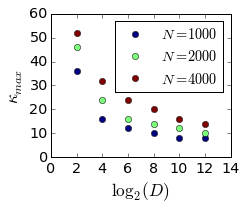

In [284]:
figure(figsize=(3.5, 3))

cm = get_cmap('jet', len(test_N))

for iN, vN in enumerate(test_N):
    clipDmax = np.zeros(len(test_D), 'int')
    for iD, vD in enumerate(test_D):
        
        clipDmax[iD] = np.argmax(clip_info_max[iN, iD, :])
        
    plot(np.log2(test_D), test_clip[clipDmax], 
         'o', lw=2, mfc=cm(iN), label='$N = %i$' % vN)
    
ylabel('$\kappa_{max}$')
xlabel('$\log_2 (D)$')

legend(loc='upper right', numpoints=1)

xlim([0,14])
plt.tight_layout()

fname = ('figures/capacity-clipping-info_max_lookback' 
         + '-nN=' + str(len(test_N))
         + '-nD=' + str(len(test_D))
         + '-nk=' + str(len(test_clip))
         + '-n' + time.strftime('%y%m%d'))
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

In [285]:
test_clip

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68,
       70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])

## Bit-per-bit capacity

In [319]:
def clip_decay_lbM(lb, M, clip=5, show_plot=False):
    '''
    Approximates the decay in the hit dot product when there is clipping. 
    '''
    
    # This is going to keep track of how many elements are a value between -clip and + clip
    # We assume that the hypervector is "filled" before a memory item is added. This means
    # that there is a uniform distribution across the values of each element.
    vec = np.zeros(2*clip+1)
    vect = np.zeros(2*clip+1)
    
    vec[clip] = 1
    

    cols1 = get_cmap('Reds_r', lb+20)
    cols2 = get_cmap('Blues_r', M+20)
    
    for cl in range(lb):
        if show_plot:
            plt.plot(arange(-clip, clip+1), vec, c=cols1(cl), lw=2)
            
        vect[:] = vec[:]
        
        # As we add more vectors/look back further in the history the distribution of the
        # elements changes. Slowly the distribution returns to uniform.
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2
        
    
    # now there is a plus one 
    vect[:] = vec[:]
    vec[1:] = vect[0:-1]
    vec[0] = 0
    vec[-1] += vect[-1]
    
    if show_plot:
        plt.plot(arange(-clip, clip+1), vec, c=cols1(cl), lw=2)
    
    for cl in range(lb, M):
        if show_plot:
            plt.plot(arange(-clip, clip+1), vec, c=cols2(cl), lw=2)
        
        vect[:] = vec[:]
        
        # As we add more vectors/look back further in the history the distribution of the
        # elements changes. Slowly the distribution returns to uniform.
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2
        
    decay = np.sum(vec * arange(-clip, clip+1))
    cvar = np.sum((arange(-clip, clip+1) - decay)**2 * vec)
    
    return decay, cvar

        

0.000479074280991 10.0000354598


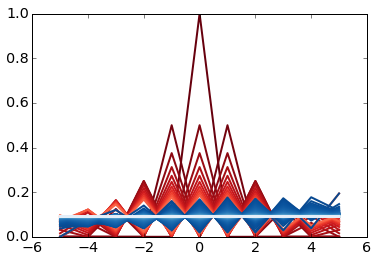

In [320]:
dec, cvar = clip_decay_lbM(20, 200, show_plot=True)
print dec, cvar

In [321]:

def p_correct_clip0_lb(M, N=1000, D=32, clip=8):
    decay, cvar = np.zeros(M), np.zeros(M)

    for lb in range(M):
        decay[lb], cvar[lb] = clip_decay_lbM(lb, M, clip=clip)
        
    s = decay * np.sqrt(N/cvar)
    s = s[::-1]

    pc = p_correct_snr(s, D=D)
    
    return pc

    
    


In [336]:
#ax=subplot(132)
test_M = arange(1, 2000, 5)
N = 2000
test_D = [4, 16, 64, 256, 1024, 4096]

test_clip = [5, 10, 20, 40, 80];

clip_info = np.zeros((len(test_M), len(test_D), len(test_clip)))
bits_x = np.zeros((len(test_D), len(test_clip)))
bits_max = np.zeros((len(test_D), len(test_clip)))

for iD, D in enumerate(test_D):
    for ic, clip in enumerate(test_clip):
        tst = time.time()
        print ic, iD, ',',
        for im, M in enumerate(test_M):
            pc1 = p_correct_clip0_lb(M=M, N=N, D=D, clip=clip)

            clip_info[im, iD, ic] = np.sum(pc1 * np.log2(pc1 * D) + (1-pc1) * np.log2(D/(D-1) * (1 - pc1)))

        bits_x[iD, ic] = np.log2(2*clip+1)
        bits_max[iD, ic] = clip_info[:, iD, ic].max()
        print ': ', time.time() - tst, 

0 0 , :  2336.68073487 1 0 , :  2278.84784818 2 0 , :  2287.99742103 3 0 , :  2313.0703299 4 0 , :  2510.40216303 0 1 , :  2229.43526912 1 1 , :  2236.47326279 2 1 , :  2258.11634398 3 1 , :  2395.73037004 4 1 , :  2593.82005 0 2 , :  2242.91472816 1 2 , :  2245.32112288 2 2 , :  2264.33154988 3 2 , :  2307.56449795 4 2 , :  2494.08638716 0 3 , :  2231.73331714 1 3 , :  2241.842273 2 3 , :  2263.96180892 3 3 , :  2312.68311286 4 3 , :  2499.35172892 0 4 , :  2245.65205312 1 4 , :  2248.18285203 2 4 , :  2263.46199298 3 4 , :  2306.56425595 4 4 , :  2494.378865 0 5 , :  2245.71620798 1 5 , :  2254.3219471 2 5 , :  2276.72366881 3 5 , :  2346.23102307 4 5 , :  2507.55488896


In [337]:
filename = ('data/clip-info_bpb-N=' + str(N) + '-lD' + str(len(test_D))
            + '-lclip' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') +'.npz')
print filename
np.savez(filename, test_M=test_M, N=N, test_D=test_D, test_clip=test_clip, clip_info=clip_info, 
         bits_x=bits_x, bits_max=bits_max)

data/clip-info_bpb-N=2000-lD6-lclip5-n170209.npz


In [65]:
ls data/clip-info_bpb*

data/clip-info_bpb-N=10000-lD5-lclip9-n161214.npz
data/clip-info_bpb-N=1000-lD5-lclip9-n161206.npz
data/clip-info_bpb-N=2000-lD5-lclip9-n161213.npz


In [5]:
h = np.load('data/clip-info_bpb-N=2000-lD5-lclip9-n161213.npz')

test_M = h['test_M']
N = h['N']
test_D = h['test_D']
test_clip = h['test_clip']
clip_info = h['clip_info']
bits_x = h['bits_x']
bits_max = h['bis_max'] #h['bits_max']

figures/capacity-bitpbit-N=2000-Dx=2-clipx=4-n170515


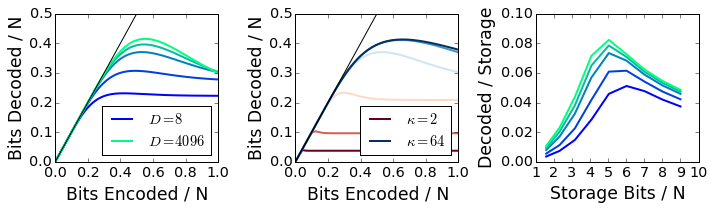

In [6]:
M = np.array(test_M)        

clip_ex = 4
D_ex = 2


figure(figsize=(10,3))

subplot(131)
cols= get_cmap('winter', len(test_D))
for iD, D in enumerate(test_D):
    if iD == 0 or iD == len(test_D) - 1:
        plot(M*np.log2(D)/N, clip_info[:, iD, clip_ex]/N, 
             '-', lw=2, c=cols(iD), label='$D = %i$' % D)
    else:
        plot(M*np.log2(D)/N, clip_info[:, iD, clip_ex]/N, 
             '-', lw=2, c=cols(iD))

plot([0, 1], [0, 1], 'k')

legend(loc='lower right')

ylabel('Bits Decoded / N')
xlabel('Bits Encoded / N')
#ax.set_xticks(arange(0, 8500, 2000))
ylim([0, 0.5])
xlim([0, 1])

subplot(132)

show_clip = arange(1, len(test_clip)-2)
cols= get_cmap('RdBu', len(show_clip))

for ic, i in enumerate(show_clip):
    if ic == 0 or ic == len(show_clip) - 1:        
        plot(M*np.log2(test_D[D_ex])/N, clip_info[:, D_ex, i] / N, '-',
             lw=2, c=cols(ic), label='$\kappa = %i$' % test_clip[i])
    else:
        plot(M*np.log2(test_D[D_ex])/N, clip_info[:, D_ex, i] / N, '-',
             lw=2, c=cols(ic))

    
plot([0, 1], [0, 1], 'k')

#plot(M, M*np.log2(test_D[D_ex])/, 'k')

ylabel('Bits Decoded / N')
xlabel('Bits Encoded / N')
#ax.set_xticks(arange(0, 8500, 2000))
ylim([0, 0.5])
xlim([0, 1])

legend(loc='lower right')

subplot(133)
cols= get_cmap('winter', len(test_D))
for iD, D in enumerate(test_D):
    plot(np.log2(2*np.array(test_clip)+1), bits_max[iD, :]/N / bits_x[iD, :], lw=2, c=cols(iD))

xlabel('Storage Bits / N')
ylabel('Decoded / Storage')
ylim([0, 0.1])
#cols= get_cmap('copper', len(test_clip))
#for ic, clip in enumerate(test_clip):
#    plot(np.log2(test_D), bits_max[:, ic]/N / bits_x[:, ic], lw=2, c=cols(ic))

plt.tight_layout()

fname = ('figures/capacity-bitpbit-N=' + str(N) + '-Dx='
         + str(D_ex) + '-clipx=' + str(clip_ex) + '-n' + time.strftime('%y%m%d')
         )
print fname

savefig(fname + '.png', 
        format='png', transparent=True)
savefig(fname + '.eps', 
        format='eps', transparent=True)

figures/capacity-bitpbit-2000-Dx=2-clipx=4-n170515


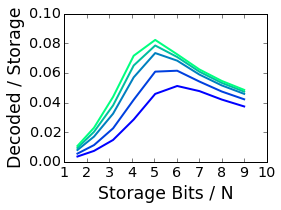

In [9]:
figure(figsize=(4,3))

cols= get_cmap('winter', len(test_D))
for iD, D in enumerate(test_D):
    plot(np.log2(2*np.array(test_clip)+1), bits_max[iD, :]/N / bits_x[iD, :], lw=2, c=cols(iD))

xlabel('Storage Bits / N')
ylabel('Decoded / Storage')
ylim([0, 0.1])
#cols= get_cmap('copper', len(test_clip))
#for ic, clip in enumerate(test_clip):
#    plot(np.log2(test_D), bits_max[:, ic]/N / bits_x[:, ic], lw=2, c=cols(ic))

plt.tight_layout()

fname = ("figures/capacity-bitpbit-" + str(N) + '-Dx='
         + str(D_ex) + '-clipx=' + str(clip_ex) + '-n' + time.strftime('%y%m%d')
         )
print fname

savefig(fname + '.png', 
        format='png', transparent=True)
savefig(fname + '.eps', 
        format='eps', transparent=True)